This example demonstrates the type-II training and inference procedure with GP-GRIEF.
By "type-II inference" we mean that the kernel hyperparameters will be estimated by maximizing the log-marginal likelihood.
We start with a one-dimensional example and then move to a multi-dimensional problem.

In [1]:
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import gp_grief
import pymcmc as pm
from sklearn.preprocessing import StandardScaler

# One-Dimensional Example
Note that in one-dimension, we cannot reap the full benefits of the efficient matrix algebra used in GP-GRIEF, however, it is helpful to start here for visualization purposes.
We begin my generating a toy dataset and initializing the inducing point grid.

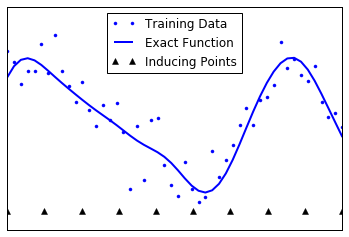

In [2]:
np.random.seed(5)
n = 50
x = np.linspace(0,1,num=n).reshape((-1,1))
k = gp_grief.kern.GPyKernel(1, kernel='RBF', lengthscale=0.1)
y_test = np.random.multivariate_normal(np.zeros(n), k.cov(x)).reshape((-1,1))
noise_var = 0.5**2
y = y_test + np.sqrt(noise_var)*np.random.randn(*y_test.shape)
grid = gp_grief.grid.InducingGrid(x=x, mbar=10)
fig,ax = plt.subplots()
plt.plot(x,y,'b.', label="Training Data")
plt.plot(x,y_test,'b-', lw=2, label="Exact Function")
plt.plot(grid.xg[0], np.zeros(grid.xg[0].shape)-2.5, 'k^', label="Inducing Points")
plt.tick_params(which='both', bottom=False, top=False, left=False, right=False, 
                labelbottom=False,labelleft=False)
plt.legend(loc=0);

Initialize the GRId-structured Eigen-Function (GRIEF) kernel to be intentionally mispecified, and then estimiate the kernel hyperparameters.
This example uses $p=10$ basis functions.

In [3]:
# initialize the GRIEF kernel and model
kern = gp_grief.kern.GriefKernel(
    kern_list=[gp_grief.kern.GPyKernel(1, kernel='RBF', lengthscale=1.),], 
    grid=grid, n_eigs=10, reweight_eig_funs=False, opt_kernel_params=True)
m_grief = gp_grief.models.GPGrief(X=x, Y=y, kern=kern, noise_var=1.)

# estimate the kernel hyperparameters
m_grief.optimize(use_counter=True);

Now plot the GRIEF kernel as well as the predictive posterior distribution (mean and standard deviation). Evidently, the estimated kernel did not exactly recover the exact kernel, however, the approximation leads to a reasonable predictive posterior distribution. 
Note that the type-I inference tutorial demonstrates how we can re-parameterize the GRIEF kernel then perform a fully Bayesian treatment of the hyperparameters very efficiently rather than making this type-II approximation.

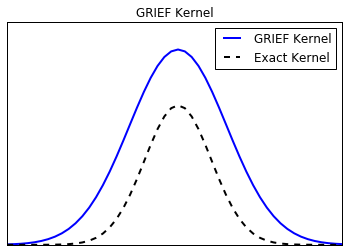

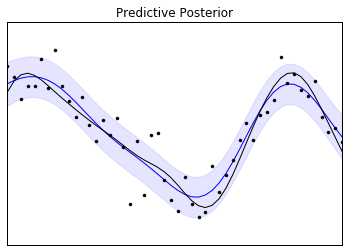

In [4]:
figs, axs = zip(*[plt.subplots() for i in range(2)])

# plot the GRIEF kernel
Phi = m_grief.kern.cov(m_grief.X)[0] #  kernel eigenfunctions evaluated on the test set
axs[0].plot(x, (Phi.dot(Phi.T))[n//2], 'b', label='GRIEF Kernel', lw=2)
axs[0].plot(x, k.cov(x)[n//2], 'k--', label='Exact Kernel', lw=2)
axs[0].legend(loc=0)
axs[0].tick_params(which='both', bottom=False, top=False, left=False, right=False, 
                   labelbottom=False,labelleft=False)
axs[0].set_title("GRIEF Kernel")

# plot the predictive posterior
y_pred_mean, y_pred_var = m_grief.predict(Xnew=x, compute_var=True)
y_pred_var = np.diagonal(y_pred_var).reshape((-1,1)) # extract variances
plt.plot(x, y_pred_mean, 'b') # plot the mean for each sample
plt.fill_between(x.squeeze(), (y_pred_mean-np.sqrt(y_pred_var)).squeeze(), 
                 (y_pred_mean+np.sqrt(y_pred_var)).squeeze(),
                 color='b', alpha=0.1) # plot +-1 std
plt.plot(x, y_test, 'k')
plt.plot(x, y, 'k.')
plt.tick_params(which='both', bottom=False, top=False, left=False, right=False, 
                labelbottom=False,labelleft=False)
plt.title("Predictive Posterior");

# Multi-Dimensional Example
We now consider a multi-dimensional example.
First import the UCI automobile dataset from a CSV file, create train/test splits, and initialize an inducing point grid with $m = 8.64 \times 10^{19}$ inducing points.
This is an amazingly large quantity of inducing points, however, constructing the GP is still tractable due to the careful matrix algebra used.

The inducing point grid should cover the input space around the training data and also the space where inference should be performed at test time.
In this example it is assumed that we know the region where inference is being performed (which is often the case) and it is ok to be a bit wasteful since computational requirements scale extremely weakly with respect to the size of the inducing point grid.
The commented lines demonstrate how the inducing point grid can be specified manually when the test set is not known; in this case $m=1.15 \times 10^{41}$ inducing points are used with little effect on runtime (and the test error performance is actually improved).

In [5]:
np.random.seed(0)
# load the datset
data = np.loadtxt(fname='automobile.csv', delimiter=',')
i_train = np.random.rand(data.shape[0]) < 0.9
n_train = i_train.sum()
x_scaler = StandardScaler();  y_scaler = StandardScaler();
x = x_scaler.fit_transform(data[:,:-1])
y = y_scaler.fit_transform(data[:,(-1,)])

# initialize the inducing point grid (when train/test set is known)
grid = gp_grief.grid.InducingGrid(x=x)

# initialize the inducing point grid manually without knowledge of test point locations
#     we randomly selecting 50 train point positions as well as an evenly spaced grid in 
#     [-3,3] along each dim. (uncomment)
# grid = gp_grief.grid.InducingGrid(
#     xg=[np.unique(np.concatenate((x[i_train,i][np.random.choice(n_train,50, replace=False)], 
#                 np.linspace(-3,3,num=30)))).reshape((-1,1)) for i in range(x.shape[1])])

# look at the size of the grid
print "Number of inducing points: m = %g" % grid.num_data

Number of inducing points: m = 8.64e+19


We can now initialize the GP-GRIEF model on the training set, estimate the kernel hyperparameters and perform inference on the test set. We will compute the root-mean squared error (RMSE) of the posterior mean on the test set.

In [6]:
# initialize the GRIEF kernel and model
kern = gp_grief.kern.GriefKernel(
    kern_list=[gp_grief.kern.GPyKernel(1, kernel='RBF', lengthscale=1.),]*x.shape[1], 
    grid=grid, n_eigs=100, reweight_eig_funs=False, opt_kernel_params=True)
m_grief = gp_grief.models.GPGrief(X=x[i_train], Y=y[i_train], kern=kern, noise_var=1.)

# estimate the kernel hyperparameters
m_grief.optimize(use_counter=True, max_iters=5)

# evaluate the posterior mean on the test set
y_pred_mean = m_grief.predict(Xnew=x[np.logical_not(i_train)], compute_var=False)

# compute the RMSE
rmse = rmse = np.linalg.norm(
    y_scaler.inverse_transform(y_pred_mean)-
    y_scaler.inverse_transform(y[np.logical_not(i_train)]))/np.sqrt(y_pred_mean.size)
print "RMSE = %f" % rmse

RMSE = 0.144395


While this is a relatively small dataset, the runtime performance of GP-GRIEF really shows on very large datasets. The runtime of this type-II approach scales linearly with the number of training points while the runtime of the type-I approach outlined in another tutorial is *independent* of the number of training points.